In [1]:
import os
os.chdir("../../../../")

import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pmdarima
from scripts.python.tsmodel import *
from scripts.python.ts_utils import *

## Load, Merge

### Load Solomon Islands' Census

In [2]:
data_folder = os.getcwd() + "/data/tourism"
samoa_folder = data_folder + "/solomon/intermediate/"

In [3]:
solomon = (pd.read_csv(samoa_folder + os.listdir(samoa_folder)[0])
           .drop(["Unnamed: 0", "Total"], axis=1))
solomon = solomon.melt(id_vars="Year")

In [4]:
from datetime import datetime
solomon["month"] = [datetime.strptime(
    str(mon), '%B').month for mon in solomon.variable]

solomon = (solomon.sort_values(["Year", "month"])
           .reset_index().drop(["index", "variable"], axis=1)
           .rename({"value": "total"}, axis=1))
solomon["date"] = [str(year) + "-" + str(month) for year, month in zip(solomon.Year, solomon.month)]
solomon["date"] = pd.to_datetime(solomon["date"])
solomon.head(5)

,Year,total,month,date
0,2009,1602,1,2009-01-01
1,2009,1422,2,2009-02-01
2,2009,1249,3,2009-03-01
3,2009,1499,4,2009-04-01
4,2009,1393,5,2009-05-01


### Load `owid-covid-data`

In [5]:
covid = pd.read_csv(data_folder + "/owid-covid-data.csv")
covid_si = (covid[covid.continent == "Oceania"][["location", "date", "stringency_index"]]
            .reset_index()
            .drop("index", axis=1))

solomon_si = (covid_si[covid_si.location == "Solomon Islands"]
              .reset_index()
              .drop("index", axis=1))
solomon_si["date"] = pd.to_datetime(solomon_si["date"])
solomon_si.head(5)

,location,date,stringency_index
0,Solomon Islands,2020-10-12,43.52
1,Solomon Islands,2020-10-13,43.52
2,Solomon Islands,2020-10-14,43.52
3,Solomon Islands,2020-10-15,43.52
4,Solomon Islands,2020-10-16,43.52


In [6]:
oceania_si = (covid_si.groupby("date").mean()
              .reset_index()
              .rename({"stringency_index": "oceania_index"}, axis=1))
oceania_si["date"] = pd.to_datetime(oceania_si["date"])

solomon_si = (oceania_si.merge(solomon_si, how="left", on="date")
              .drop("location", axis=1))

In [7]:
solomon_si["year"], solomon_si["month"] = \
    solomon_si["date"].dt.year, solomon_si["date"].dt.month
solomon_si = solomon_si.groupby(["year", "month"]).mean().reset_index()
solomon_si["date"] = [str(year) + "-" + str(month)
                      for year, month in zip(solomon_si.year, solomon_si.month)]
solomon_si["date"] = pd.to_datetime(solomon_si["date"])
solomon_si = solomon_si.drop(["year", "month"], axis=1)

In [8]:
solomon = solomon.merge(solomon_si, how="left", on="date").fillna(0)
solomon.head(5)

,Year,total,month,date,oceania_index,stringency_index
0,2009,1602,1,2009-01-01,0.0,0.0
1,2009,1422,2,2009-02-01,0.0,0.0
2,2009,1249,3,2009-03-01,0.0,0.0
3,2009,1499,4,2009-04-01,0.0,0.0
4,2009,1393,5,2009-05-01,0.0,0.0


## Preprocessing

In [9]:
total_size = len(solomon)
train_size = int(0.9 * total_size)
test_size = total_size - train_size

train, test = model_selection.train_test_split(
    solomon[["date", "total", "oceania_index"]], train_size=train_size)
print("train size : {}, test_size : {}".format(train_size, test_size))

train size : 129, test_size : 15


In [10]:
get_adf_df(train.diff()[1:], ["total"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
total,-7.575825,2.763482e-11,10.0,117.0,-3.487517,-2.886578,-2.580124


## Modeling

In [11]:
stepwise_fit = auto_arima(solomon["total"], exog=solomon["oceania_index"],
                          start_p=1, start_q=1,
                          max_p=5, max_q=5, m=12,
                          start_P=0, seasonal=True,
                          d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1888.103, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1952.411, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1909.213, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1887.618, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1940.531, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1888.389, Time=0.21 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1887.944, Time=0.59 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1910.345, Time=0.07 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1889.539, Time=1.32 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1893.062, Time=0.07 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1886.294, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1940.332, Time=0.01 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1887.086, Time=0.26 sec
 ARIMA(1,1,0)(0,1,2)[12]

Ljung-box p-values:
[0.50981851 0.2875432  0.47396844 0.6156702  0.68184743 0.73887212
 0.82776133 0.77740463 0.8411601  0.89561873 0.90007011 0.90363487
 0.93694796 0.95306947 0.97054263 0.98195185 0.98384567 0.99014758
 0.99421361 0.99630416 0.99698037 0.99501279 0.99372009 0.99462155]


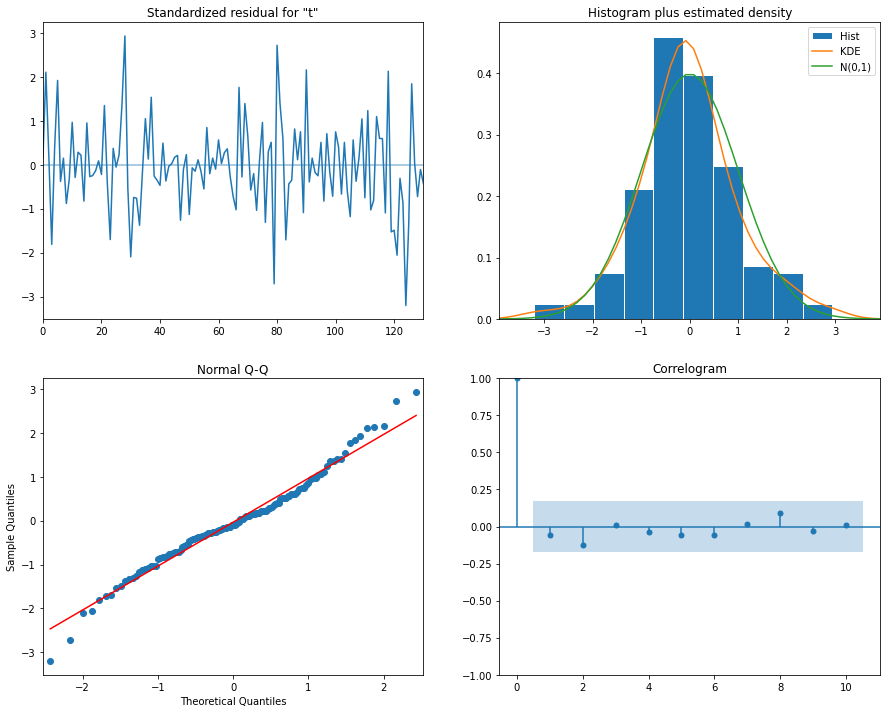

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              total   No. Observations:                  144
Model:             ARIMA(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -930.252
Date:                            Mon, 27 Feb 2023   AIC                           1868.503
Time:                                    21:49:32   BIC                           1880.004
Sample:                                         0   HQIC                          1873.176
                                            - 144                                         
Covariance Type:                              opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
oceania_index   -20.7917      3.342     -6.221      0.000     -27.342     -14.241
ar.L1            -0.3619      0.068     -5.290      0.000      -0.496      -0.228
ma.S.L12         -0.9293      0.269     -3.451      0.001      -1.457      -0.401
sigma2         7.319e+04   1.61e+04      4.532      0.000    4.15e+04    1.05e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                 5.44
Prob(Q):                              0.51   Prob(JB):                         0.07
Heteroskedasticity (H):               1.17   Skew:                             0.12
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
arma_mod = ARIMA(solomon["total"], exog=solomon["oceania_index"],
                 order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
arma_res = arma_mod.fit()

print("Ljung-box p-values:\n" +
      str(arma_res.test_serial_correlation(method='ljungbox')[0][1]))
arma_res.plot_diagnostics(figsize=(15, 12))
plt.show()
arma_res.summary()

### Fitting

In [13]:
pred_df = arma_res.get_prediction().summary_frame(alpha=0.05)
solomon = pd.concat([solomon, pred_df], axis=1)
solomon.head(5)

,Year,total,month,date,oceania_index,stringency_index,mean,mean_se,mean_ci_lower,mean_ci_upper
0,2009,1602,1,2009-01-01,0.0,0.0,0.000000,1468.650268,-2878.501632,2878.501632
1,2009,1422,2,2009-02-01,0.0,0.0,1559.821977,1074.913235,-546.969249,3666.613204
2,2009,1249,3,2009-03-01,0.0,0.0,1443.970255,1074.243782,-661.508869,3549.449379
3,2009,1499,4,2009-04-01,0.0,0.0,1250.470478,1074.178048,-854.879808,3355.820764
4,2009,1393,5,2009-05-01,0.0,0.0,1486.460529,1074.171612,-618.877144,3591.798203


In [17]:
future_exog = solomon_si[solomon_si.date> "2020-12-31"]["oceania_index"].dropna()
future = arma_res.get_forecast(steps=24, exog=future_exog).summary_frame()
future["date"] = pd.date_range(start="2021-01-01", freq="MS", periods=24)
future.head(5)

total,mean,mean_se,mean_ci_lower,mean_ci_upper,date
144,-367.146408,274.899929,-905.940368,171.647552,2021-01-01
145,-365.402240,325.911789,-1004.177609,273.373128,2021-02-01
146,-126.812666,388.226528,-887.722679,634.097347,2021-03-01
147,-140.252161,435.790652,-994.386144,713.881822,2021-04-01
148,-206.264955,480.612771,-1148.248676,735.718767,2021-05-01


Text(0.5, 1.0, "Solomon Islands' Visitor Arrivals")

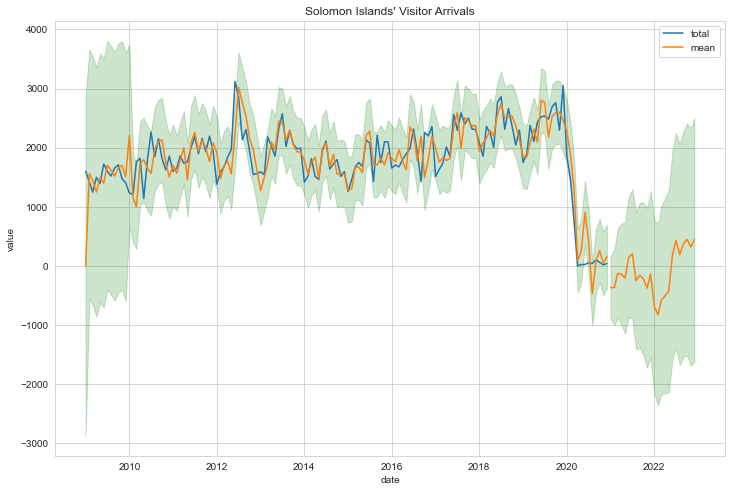

In [21]:
viz_df = solomon[["date", "total", "mean"]].melt(id_vars=["date"])
viz_df["date"] = pd.to_datetime(viz_df["date"])

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=viz_df, x="date", y="value", hue="variable")
ax.fill_between(data=solomon, x="date", y1="mean_ci_lower", y2="mean_ci_upper", alpha=0.2, color="green")
ax.fill_between(data=future, x="date", y1="mean_ci_lower", y2="mean_ci_upper", alpha=0.2, color="green")
sns.lineplot(data=future, x="date", y="mean")
plt.title("Solomon Islands' Visitor Arrivals")